# Predicting student chance applying to a University

### Context
This dataset is created for prediction of Graduate Admissions from an Indian perspective.

### Content
The dataset contains several parameters which are considered important during the application for Masters Programs.
The parameters included are :

GRE Scores ( out of 340 )
TOEFL Scores ( out of 120 )
University Rating ( out of 5 )
Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
Undergraduate GPA ( out of 10 )
Research Experience ( either 0 or 1 )
Chance of Admit ( ranging from 0 to 1 )
Acknowledgements
This dataset is inspired by the UCLA Graduate Dataset. The test scores and GPA are in the older format.
The dataset is owned by Mohan S Acharya.

### Inspiration
This dataset was built with the purpose of helping students in shortlisting universities with their profiles. The predicted output gives them a fair idea about their chances for a particular university.

### Citation
Please cite the following if you are interested in using the dataset :
Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019

I would like to thank all of you for contributing to this dataset through discussions and questions. I am in awe of the number of kernels built on this dataset. Some results and visualisations are fantastic and makes me a proud owner of the dataset. Keep em' coming! Thank You.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Load Dataset

In [2]:
df = pd.read_csv("Admission_Predict_Ver1.1.csv", index_col="Serial No.")
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
from jcopml.plot import plot_missing_value

,missing_value,%
GRE Score,0,0.0
TOEFL Score,0,0.0
University Rating,0,0.0
SOP,0,0.0
LOR,0,0.0
CGPA,0,0.0
Research,0,0.0
Chance of Admit,0,0.0


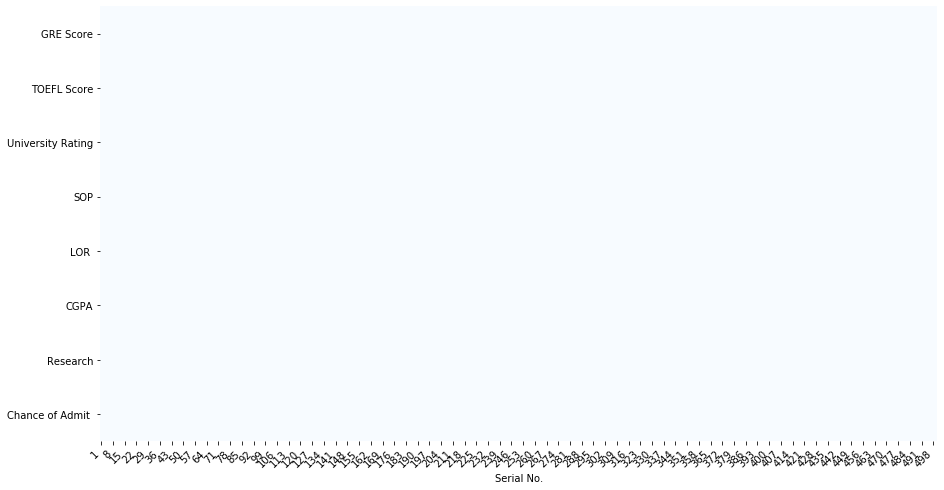

In [4]:
plot_missing_value(df, return_df=True)

# Data Splitting

In [5]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [6]:
X = df.drop(columns="Chance of Admit ")
y = df["Chance of Admit "]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 7), (100, 7), (400,), (100,))

# Training Model

### Elastic Net

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [8]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']),
    ('categoric', cat_pipe(encoder='onehot'), ['Research']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = GridSearchCV(pipeline, gsp.enet_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s


{'algo__alpha': 0.001, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.5}
0.8208615397611957 0.8093937897865692 0.8163483557363886


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   14.5s finished


# Evaluation

In [9]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

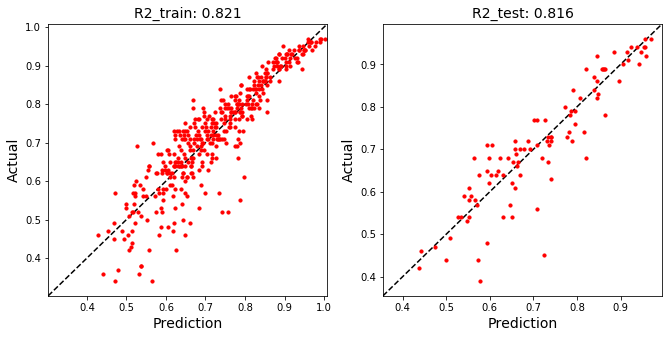

In [10]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

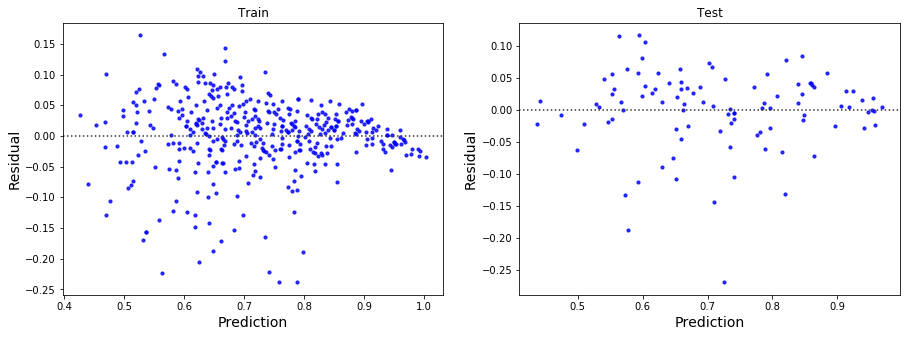

In [11]:
plot_residual(X_train, y_train, X_test, y_test, model)

### Our residual indicating Heteroscedasticity so we need to Scale & Transform our numerical features

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson'), ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']),
    ('categoric', cat_pipe(encoder='onehot'), ['Research']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = GridSearchCV(pipeline, gsp.enet_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 60 candidates, totalling 180 fits


C:\Users\ASUS\miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    8.9s finished


{'algo__alpha': 0.001, 'algo__fit_intercept': False, 'algo__l1_ratio': 0.5}
0.8206425935235024 0.809127032446156 0.8197726827679608


- Our model improve a little bit, but not significant

# Feature Importance

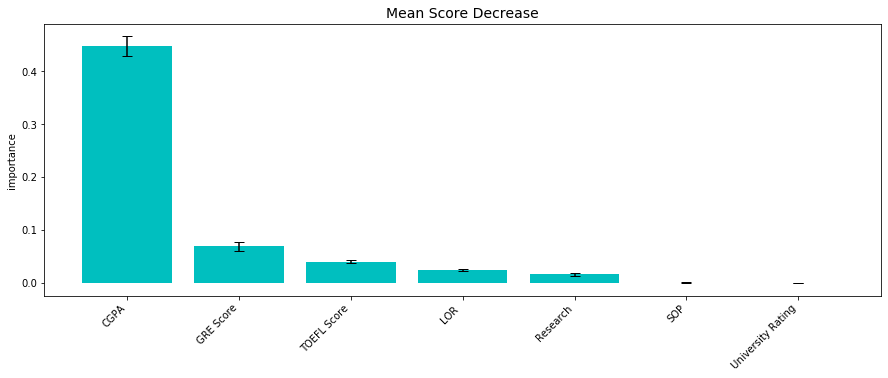

In [13]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)